In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


In [4]:

# ----------------------------
# 1. Função: Mistura de Gaussianas
# ----------------------------
def gaussian_mixture_density(x, clusters):
    total_density = 0
    total_points = sum(len(cluster) for cluster in clusters)
    
    for cluster in clusters:
        weight = len(cluster) / total_points
        mean = np.mean(cluster, axis=0)
        cov = np.cov(cluster.T)
        rv = multivariate_normal(mean=mean, cov=cov)
        total_density += weight * rv.pdf(x)
    
    return total_density

def generate_clusters(n=100, std=0.5):
    cluster_1 = np.random.randn(n, 2) * std + np.array([2, 3])
    cluster_2 = np.random.randn(n, 2) * std + np.array([4, 3])
    cluster_3 = np.random.randn(n, 2) * std + np.array([3, 4])
    cluster_4 = np.random.randn(n, 2) * std + np.array([3, 2])
    return np.vstack([cluster_1, cluster_2, cluster_3, cluster_4])

def cluster_data(data, k=4):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    clusters = [data[kmeans.labels_ == i] for i in range(k)]
    return clusters

def compute_density_grid(clusters, x_range, y_range):
    X = np.arange(*x_range)
    Y = np.arange(*y_range)
    Z = np.zeros((len(X), len(Y)))

    for i, xi in enumerate(X):
        for j, yj in enumerate(Y):
            Z[i, j] = gaussian_mixture_density([xi, yj], clusters)

    return X, Y, Z

def plot_results(data, X, Y, Z):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c='red', s=10)
    plt.contour(X, Y, Z.T, levels=10)
    plt.title('Contornos da mistura de gaussianas')
    plt.xlim(0, 6)
    plt.ylim(0, 6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X_mesh, Y_mesh = np.meshgrid(X, Y)
    ax.plot_surface(X_mesh, Y_mesh, Z.T, cmap='Reds', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Densidade')
    plt.title('Superfície 3D da mistura')
    plt.show()

In [6]:
data = generate_clusters()
clusters = cluster_data(data)
X, Y, Z = compute_density_grid(clusters, (0, 6.1, 0.1), (0, 6.05, 0.05))
plot_results(data, X, Y, Z)

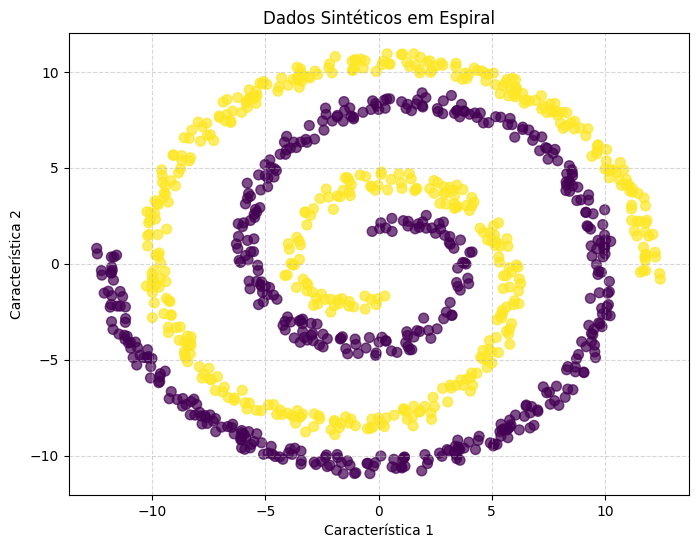

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral_data(n_points, noise=0.5, turns=1.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * turns * (2 * np.pi)
    d_x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d_y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    return (np.vstack((np.hstack((d_x, d_y)), np.hstack((-d_x, -d_y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))

n_samples = 1000
X_spiral, y_spiral = generate_spiral_data(n_samples // 2, noise=1.0, turns=2.0)

plt.figure(figsize=(8, 6))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, cmap='viridis', s=50, alpha=0.7)
plt.title('Dados Sintéticos em Espiral')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [29]:
def compute_density_grid_optimized(clusters, grid_points_flat, grid_shape):
    # Inicializa a densidade total com zeros
    total_density = np.zeros(len(grid_points_flat))
    total_points = sum(len(cluster) for cluster in clusters)

    for cluster in clusters:
        # Ignora clusters com menos de 2 pontos
        if len(cluster) < 2:
            continue

        # Calcula o peso do cluster
        peso_cluster = len(cluster) / total_points

        # Calcula a média do cluster
        media_cluster = np.mean(cluster, axis=0)

        # Calcula e ajusta a matriz de covariância
        matriz_cov = np.cov(cluster.T)
        matriz_cov = ajusta_matriz_covariancia(matriz_cov, cluster.shape[1])

        # Calcula a densidade para o cluster atual e adiciona à densidade total
        densidade_cluster = multivariate_normal(media_cluster, matriz_cov).pdf(grid_points_flat)
        total_density += peso_cluster * densidade_cluster

    # Retorna a densidade total reshape para a forma da grade
    return total_density.reshape(grid_shape)

def ajusta_matriz_covariancia(matriz_cov, dimensao):
    # Garante que a matriz de covariância seja positiva definida
    autovalor_minimo = np.min(np.linalg.eigvals(matriz_cov))
    if autovalor_minimo < 0:
        matriz_cov -= 10 * autovalor_minimo * np.eye(dimensao)
    
    # Adiciona uma pequena perturbação para estabilidade numérica
    matriz_cov += np.eye(dimensao) * 1e-6
    
    return matriz_cov

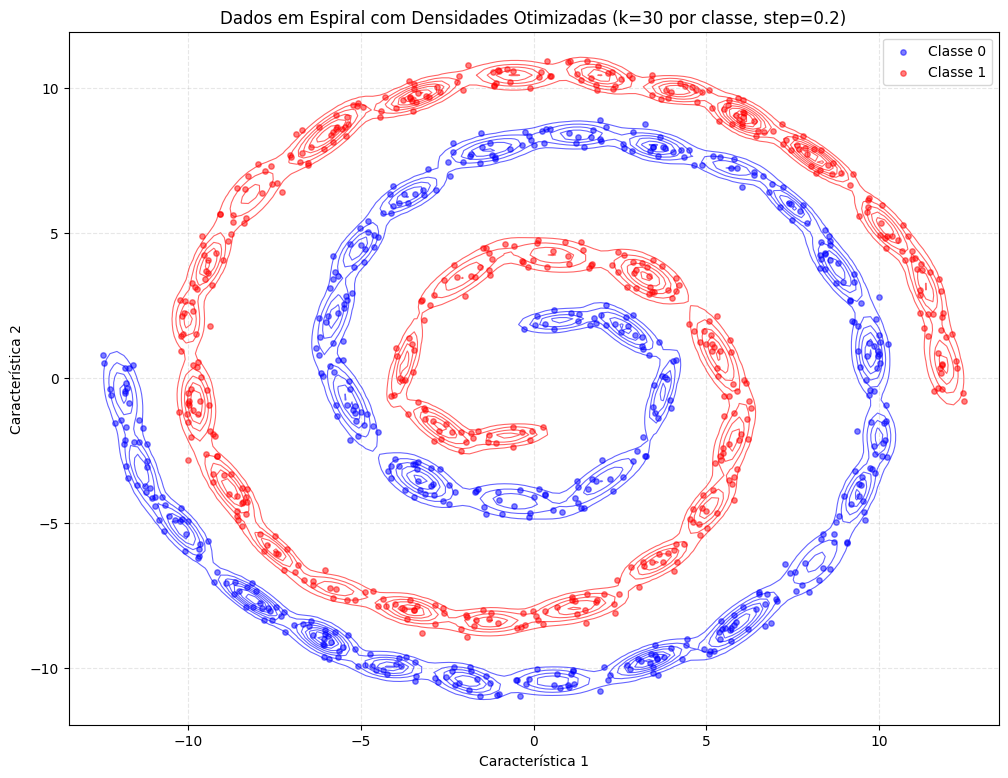

In [30]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import time

X_class0 = X_spiral[y_spiral == 0]
X_class1 = X_spiral[y_spiral == 1]

k_per_class = 30
clusters0 = cluster_data(X_class0, k=k_per_class)
clusters1 = cluster_data(X_class1, k=k_per_class)

x_min, x_max = X_spiral[:, 0].min() - 1, X_spiral[:, 0].max() + 1
y_min, y_max = X_spiral[:, 1].min() - 1, X_spiral[:, 1].max() + 1
grid_step = 0.2

X_grid_axis = np.arange(x_min, x_max, grid_step)
Y_grid_axis = np.arange(y_min, y_max, grid_step)
X_grid, Y_grid = np.meshgrid(X_grid_axis, Y_grid_axis)
grid_points_flat = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T




Z0 = compute_density_grid_optimized(clusters0, grid_points_flat, X_grid.shape)
Z1 = compute_density_grid_optimized(clusters1, grid_points_flat, X_grid.shape)


plt.figure(figsize=(12, 9))
plt.contour(X_grid, Y_grid, Z0, levels=8, colors='blue', alpha=0.6, linewidths=0.8)
plt.contour(X_grid, Y_grid, Z1, levels=8, colors='red', alpha=0.6, linewidths=0.8)
plt.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', s=15, label='Classe 0', alpha=0.5)
plt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', s=15, label='Classe 1', alpha=0.5)
plt.title(f'Dados em Espiral com Densidades Otimizadas (k={k_per_class} por classe, step={grid_step})')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()



In [34]:
import numpy as np

def gaussian_kernel(u, h):
    """Kernel Gaussiano univariado"""
    return (1 / np.sqrt(2 * np.pi * h * h)) * np.exp(-0.5 * u ** 2)

def kde_estimate(xrange, X, h):
    """
    Estimativa de densidade por kernel Gaussiano univariado.
    
    xrange: pontos onde a densidade será avaliada (array NxD)
    X: amostra dos dados (array MxD)
    h: parâmetro de suavização (bandwidth)
    
    Retorna: vetor de densidades avaliadas em cada ponto de xrange
    """
    N = X.shape[0]
    Nxrange = xrange.shape[0]
    px = np.zeros(Nxrange)

    for i in range(Nxrange):
        xi = xrange[i]
        k_sum = 0
        for j in range(N):
            xj = X[j]
            dist = np.linalg.norm(xi - xj)
            u = dist / h
            k_sum += gaussian_kernel(u, h)
        px[i] = k_sum

    px = px / N
    return px


Bandwidth calculado (h4): 0.5381


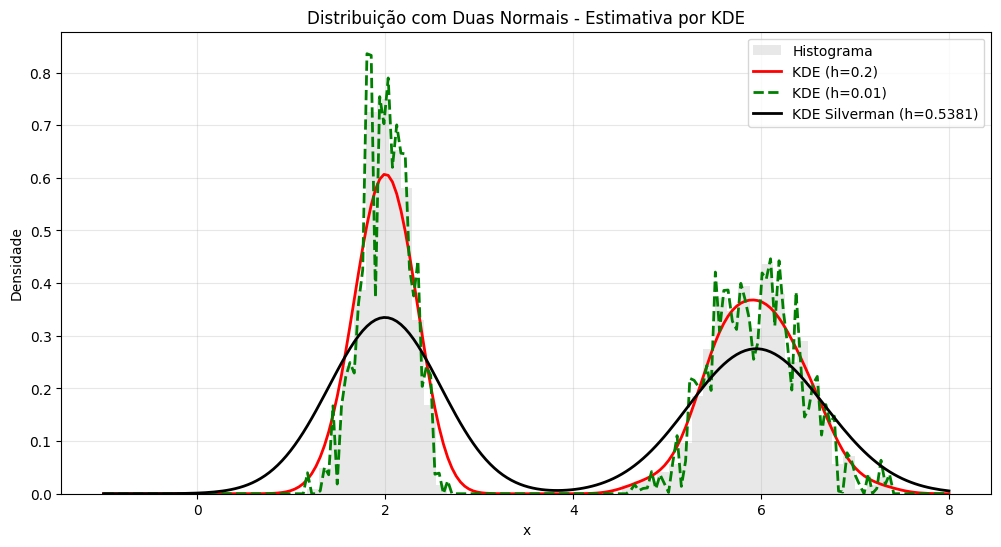

In [42]:
n_points = 500
dados_normal1 = np.random.normal(loc=2, scale=0.25, size=n_points)
dados_normal2 = np.random.normal(loc=6, scale=0.5, size=n_points)

dados = np.concatenate([dados_normal1, dados_normal2])

# Calcular h4 usando a regra de Silverman
n = len(dados)
std_estimado = np.std(dados)
h4 = 1.06 * std_estimado * (n ** (-1/5))
print(f"Bandwidth calculado (h4): {h4:.4f}")

x_range = np.linspace(-1, 8, 200).reshape(-1, 1)
dados = dados.reshape(-1, 1)

h1 = 0.2
h3 = 0.01
kde1 = kde_estimate(x_range, dados, h1)
kde3 = kde_estimate(x_range, dados, h3)
kde4 = kde_estimate(x_range, dados, h4)

plt.figure(figsize=(12, 6))
plt.hist(dados, bins=50, density=True, alpha=0.5, color='lightgray', label='Histograma')
plt.plot(x_range, kde1, 'r-', lw=2, label=f'KDE (h={h1})')
plt.plot(x_range, kde3, 'g--', lw=2, label=f'KDE (h={h3})')
plt.plot(x_range, kde4, 'k-', lw=2, label=f'KDE Silverman (h={h4:.4f})')
plt.title('Distribuição com Duas Normais - Estimativa por KDE')
plt.xlabel('x')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
# ... código univariado existente ...

# %% [markdown]
# ## Implementação KDE Multivariável

# %%
def gaussian_kernel_multivariate(u_squared, d):
    return (2 * np.pi)**(-d / 2) * np.exp(-0.5 * u_squared)

def kde_estimate_multivariate(xrange, X, h):
    M, d = X.shape
    N = xrange.shape[0]
    px = np.zeros(N)
    norm_factor = 1.0 / (M * (h ** d))
    for i in range(N):
        xi = xrange[i, :]
        k_sum = 0.0
        for j in range(M):
            xj = X[j, :]
            dist_sq = np.sum((xi - xj) ** 2)
            u_squared = dist_sq / (h ** 2)
            k_sum += gaussian_kernel_multivariate(u_squared, d)
        px[i] = norm_factor * k_sum
    return px

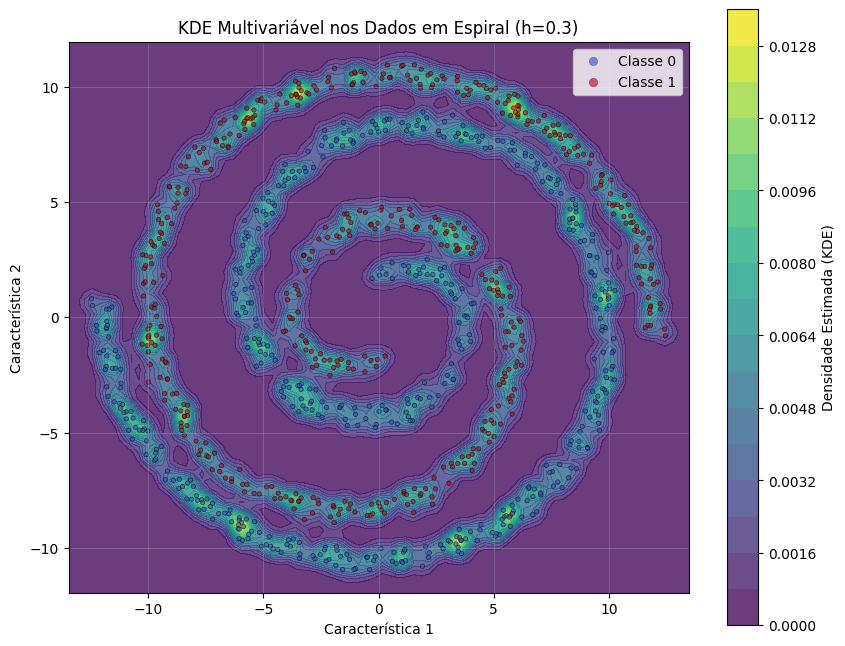

In [46]:
grid_res_spiral = 80 
x_min_spiral, x_max_spiral = X_spiral[:, 0].min() - 1, X_spiral[:, 0].max() + 1
y_min_spiral, y_max_spiral = X_spiral[:, 1].min() - 1, X_spiral[:, 1].max() + 1

x_coords_spiral = np.linspace(x_min_spiral, x_max_spiral, grid_res_spiral)
y_coords_spiral = np.linspace(y_min_spiral, y_max_spiral, grid_res_spiral)
X_grid_spiral, Y_grid_spiral = np.meshgrid(x_coords_spiral, y_coords_spiral)

xrange_spiral = np.vstack([X_grid_spiral.ravel(), Y_grid_spiral.ravel()]).T

bandwidth_spiral = 0.3


Z_kde_spiral = kde_estimate_multivariate(xrange_spiral, X_spiral, bandwidth_spiral)


Z_grid_spiral = Z_kde_spiral.reshape(X_grid_spiral.shape)

plt.figure(figsize=(10, 8))

plt.contourf(X_grid_spiral, Y_grid_spiral, Z_grid_spiral, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(label='Densidade Estimada (KDE)')

scatter = plt.scatter(X_spiral[:, 0], X_spiral[:, 1], s=10, c=y_spiral, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)

plt.title(f'KDE Multivariável nos Dados em Espiral (h={bandwidth_spiral})')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Classe 0', 'Classe 1']) 
plt.grid(True, alpha=0.3)
plt.axis([x_min_spiral, x_max_spiral, y_min_spiral, y_max_spiral]) 
plt.gca().set_aspect('equal', adjustable='box') 
plt.show()
